**Import Libraries**

In [1]:
import numpy as np
from PIL import Image 
import glob # used to read images
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

**Mount the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'drive/My Drive/orl_dataset'

README	s11  s14  s17  s2   s22  s25  s28  s30	s33  s36  s39  s5  s8
s1	s12  s15  s18  s20  s23  s26  s29  s31	s34  s37  s4   s6  s9
s10	s13  s16  s19  s21  s24  s27  s3   s32	s35  s38  s40  s7


**Constants**

In [ ]:
root_path = 'drive/My Drive/orl_dataset'
image_length = 10304 #  92x112
subjects_length = 40
number_of_images = 400 # 40*10

# Preparing the data

***Generate the Data Matrix and the Label vector***

In [ ]:

data = np.empty((0,image_length), int)
images = []
label_id = []

#reading paths of all images
for i in range(1, subjects_length + 1):
  path = root_path + '/s' + str(i) + '/'
  for k in range(1, 11):
    images += glob.glob(path + '/' + str(k) + '.pgm')

id = 1
cnt = 0

#converting images to arrays and prepare label vector
for image in images:
  img= Image.open(image)

  #converting each image to a row vector of size (1 , 10304)
  np_img = np.array(img).reshape(1, image_length)

  #stacking the imges into one matrix
  data = np.vstack((data,np_img))

  #generate the label vector
  label_id.append(id)
  cnt += 1
  if cnt == 10:
    id += 1
    cnt = 0
print(data.shape)
label_id = np.array(label_id).reshape(number_of_images, 1)
# here we have data contains the images and label_id contains the id of the image




(400, 10304)


**Split the Dataset into Training and Test sets**

In [ ]:
train_data = data[::2]
train_label = label_id[::2]
test_data = data[1::2]
test_label = label_id[1::2]

# PCA Classification

**PCA algorithm implementation**

In [ ]:
def PCA(data, alpha):
  data_length = len(data)
  mean = np.mean(data, axis = 0).reshape(1, image_length)  #calculate the mean.
  z = data - mean
  cov = np.dot(z.transpose(), z) / (data_length)   #Covariance matrix
  ign_values, ign_vectors = np.linalg.eigh(cov)   #eigenvalus and vectors ordered in descending order.
  idx = ign_values.argsort()[::-1]   
  ign_values = ign_values[idx]
  ign_vectors = ign_vectors[:,idx]

  #choosing r that f(r) >= alpha and take the right eigenvectors.
  ign_sum = np.sum(ign_values)   
  r = 0
  pref_sum = 0;
  for i in range(len(ign_values)):
    r += 1
    pref_sum += ign_values[i]
    if (float(pref_sum) / ign_sum) >= alpha:
      break
  projection = ign_vectors[::, :r]
  return projection
  

**Project Test and Train matrix on projection matrix**

In [ ]:
def getMatrixProjection(matrix, projection_matrix):
  return np.dot(matrix, projection_matrix)

**Get The Accuracy**

In [ ]:
def accuracy(prediction, actual):
  equal = 0;
  for i in range(len(prediction)):
    if prediction[i] == actual[i]:
      equal += 1
  return float(equal / len(actual))

**Simple classifier using first nearst neughbour**

In [ ]:
def first_nearst_classifier(train_data, train_label, test_data):
  fnn = KNeighborsClassifier(n_neighbors=1)
  fnn.fit(train_data, train_label.reshape(200, ))
  test_predictions = fnn.predict(test_data)
  return test_predictions

**Calculate PCA Accuracy for different ALPHA**

In [ ]:
alphas = [.8, .85, .9, .95]
for alpha in alphas:
  projection = PCA(train_data, alpha)
  train_projection = getMatrixProjection(train_data, projection)
  test_projection = getMatrixProjection(test_data, projection)
  test_prediction = first_nearst_classifier(train_projection, train_label, test_projection)
  acc = accuracy(test_prediction.reshape(200,1), test_label.reshape(200,1))
  print("For Alpha : " + str(alpha) + "    The accuracy : " + str(acc))

For Alpha : 0.8    The accuracy : 0.95
For Alpha : 0.85    The accuracy : 0.95
For Alpha : 0.9    The accuracy : 0.94
For Alpha : 0.95    The accuracy : 0.94


# LDA Classification

**LDA Model**

In [ ]:
 def LDA(data):
   overall_mean = np.zeros((subjects_length, image_length))
   B = np.zeros((image_length,image_length))
   S = np.zeros((image_length,image_length))

   #calculating the mean of each class and overall mean.
   overall_mean = np.mean(data,axis=0).reshape(1,image_length)
   

   #Calculating B matrix and S matrix.
   for i in range(40):
    start = i * 5
    group_data = data[start:start + 5, :]
    mean = np.mean(group_data, axis = 0).reshape(1, image_length)
    dif_mean = overall_mean - mean
    temp_B = np.dot(dif_mean.transpose(), dif_mean)
    B = B + temp_B
    #calculating S matrix.
    z = group_data - mean
    sx = np.dot(z.transpose(), z)
    S = S + sx
   
   B = 5 * B

   print('B matrix Shape: ')
   print(B.shape)
   print('S matrix Shape: ')
   print(S.shape)
   #inverse S and calculate S^-1 * B
   S_inv = np.linalg.inv(S)
   A = np.dot(S_inv, B)
   #calculate eigenvalues and eigenvetors sorted discendent order.
   ign_values, ign_vectors = np.linalg.eigh(A)   
   ign_values = ign_values[::-1]
   ign_vectors = ign_vectors[:,::-1]

   
   #get projection matrix U 10304 x 39 
   projection_matrix = ign_vectors[:, 0:39]
   print('Projection matrix shape : ')
   print(projection_matrix.shape)
   return projection_matrix


**Calling Methods in order**

In [ ]:
projection = LDA(train_data)
train_projection_LDA = getMatrixProjection(train_data, projection)
test_projection_LDA = getMatrixProjection(test_data, projection)
test_prediction_LDA = first_nearst_classifier(train_projection_LDA, train_label, test_projection_LDA)
acc_LDA = accuracy(test_prediction_LDA.reshape(200,1), test_label.reshape(200,1))
print('Accuracy : ')
print(acc_LDA)

B matrix Shape: 
(10304, 10304)
S matrix Shape: 
(10304, 10304)
Projection matrix shape : 
(10304, 39)
Accuracy : 
0.95


# Classifier Tuning

**K-nearst neighboor**

In [ ]:
def k_nearst_classifier(train_date, train_label, test_data, k):
  fnn = KNeighborsClassifier(n_neighbors=k)
  fnn.fit(train_date, train_label.reshape(200, ))
  test_predictions = fnn.predict(test_data)
  return test_predictions

**LDA with K-neighboors**

In [ ]:
 k_s = [1,3,5,7]
 # for LDA
 answers = []
 projection = LDA(train_data)
 train_projection_LDA = getMatrixProjection(train_data, projection)
 test_projection_LDA = getMatrixProjection(test_data, projection)
 print('K_s : ')
 print(k_s)
 print('Accuracy : ')
 for k in k_s:   
   test_prediction_LDA = k_nearst_classifier(train_projection_LDA, train_label, test_projection_LDA, k)
   acc_LDA = accuracy(test_prediction_LDA.reshape(200,1), test_label.reshape(200,1))
   answers.append(acc_LDA)
 print(answers)

B matrix Shape: 
(10304, 10304)
S matrix Shape: 
(10304, 10304)
Projection matrix shape : 
(10304, 39)
K_s : 
[1, 3, 5, 7]
Accuracy : 
[0.95, 0.865, 0.81, 0.77]


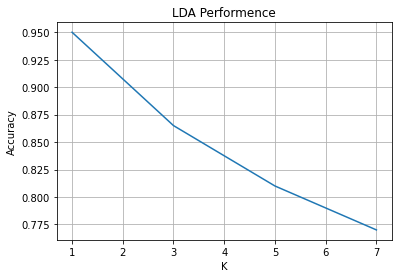

In [ ]:
import matplotlib.pyplot as pl
pl.plot([1,3,5,7],[0.95, 0.865, 0.81, 0.77])
pl.xlabel('K')
pl.ylabel('Accuracy')
pl.grid(True)
pl.title('LDA Performence')
pl.show()

**PCA with K-Neighbours**

In [ ]:
# for PCA
alphas = [.8, .85, .9, .95]
total_answers = []
for alpha in alphas:
  projection = PCA(train_data, alpha)
  train_projection = getMatrixProjection(train_data, projection)
  test_projection = getMatrixProjection(test_data, projection)
  print("ALPHA : " + str(alpha))
  answers = []
  for k in k_s:
    test_prediction = k_nearst_classifier(train_projection, train_label, test_projection, k)
    acc = accuracy(test_prediction.reshape(200,1), test_label.reshape(200,1))
    print("For K : " + str(k) +  "    The accuracy : " + str(acc))
    answers.append(acc)
  total_answers.append(answers)

print(total_answers)


ALPHA : 0.8
For K : 1    The accuracy : 0.95
For K : 3    The accuracy : 0.895
For K : 5    The accuracy : 0.85
For K : 7    The accuracy : 0.805
ALPHA : 0.85
For K : 1    The accuracy : 0.95
For K : 3    The accuracy : 0.895
For K : 5    The accuracy : 0.845
For K : 7    The accuracy : 0.775
ALPHA : 0.9
For K : 1    The accuracy : 0.94
For K : 3    The accuracy : 0.89
For K : 5    The accuracy : 0.835
For K : 7    The accuracy : 0.77
ALPHA : 0.95
For K : 1    The accuracy : 0.94
For K : 3    The accuracy : 0.895
For K : 5    The accuracy : 0.845
For K : 7    The accuracy : 0.74
[[0.95, 0.895, 0.85, 0.805], [0.95, 0.895, 0.845, 0.775], [0.94, 0.89, 0.835, 0.77], [0.94, 0.895, 0.845, 0.74]]


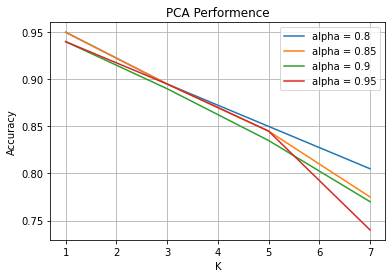

In [ ]:
import matplotlib.pyplot as pl
my_K = [1,3,5,7] 
pl.xlabel('K')
pl.ylabel('Accuracy')
pl.title('PCA Performence')

pl.plot(my_K, [0.95, 0.895, 0.85, 0.805],label='alpha = 0.8')
pl.plot(my_K, [0.95, 0.895, 0.845, 0.775],label='alpha = 0.85')
pl.plot(my_K, [0.94, 0.89, 0.835, 0.77],label='alpha = 0.9')
pl.plot(my_K, [0.94, 0.895, 0.845, 0.74],label='alpha = 0.95')

pl.legend()
pl.grid(True)
pl.show()